In [88]:
# Manipulação de dados
import collections
import numpy as np
import os
import pandas as pd
import statistics
import sys
import time
import timeit

# Estatística e testes estatísticos
import statsmodels.api as sm
from scipy import stats
from scipy.stats import (
    anderson, chi2_contingency, f_oneway, kstest, normaltest,
    shapiro, ttest_rel, wilcoxon
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Salvamento e análise de tamanho do modelo
import joblib
from pympler import asizeof

# Pré-processamento
import missingno as msno
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler
)

# Divisão do dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Parametrização
from sklearn.model_selection import GridSearchCV


# Modelos de aprendizado de máquina
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Métricas de avaliação
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, mean_squared_error,
    precision_score, r2_score, recall_score, silhouette_score,
    mean_absolute_error, mean_absolute_percentage_error,
    median_absolute_error, max_error,
    roc_auc_score, average_precision_score, log_loss,
    matthews_corrcoef, cohen_kappa_score, brier_score_loss,
    hamming_loss, jaccard_score, fbeta_score,
    balanced_accuracy_score, zero_one_loss,
    silhouette_score, calinski_harabasz_score, davies_bouldin_score, classification_report
)

# Dimensionalidade
from sklearn.decomposition import PCA

# Visualização
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### 2. CARREGAMENTO DOS DADOS

In [2]:
experimento_02 = pd.read_csv('data/Student Mental health.csv')
print("Dimensões do dataset original:", experimento_02.shape)
experimento_02.info()

Dimensões do dataset original: (101, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Timestamp                                     101 non-null    object 
 1   Choose your gender                            101 non-null    object 
 2   Age                                           100 non-null    float64
 3   What is your course?                          101 non-null    object 
 4   Your current year of Study                    101 non-null    object 
 5   What is your CGPA?                            101 non-null    object 
 6   Marital status                                101 non-null    object 
 7   Do you have Depression?                       101 non-null    object 
 8   Do you have Anxiety?                          101 non-null    object 
 9   Do you have Panic attack

### 3. PRÉ-PROCESSAMENTO E LIMPEZA CENTRALIZADOS
- Nesta seção, todas as modificações no DataFrame são feitas de uma só vez para garantir consistência.

In [3]:
df = experimento_02.copy()

#### --- 3.1 Limpeza Inicial ---

In [4]:
df.replace('Missing value', np.nan, inplace=True)

Renomear coluna de gênero para simplificar

In [5]:
df.rename(columns={'Choose your gender': 'gender'}, inplace=True)

Tratamento de valores nulos

In [6]:
print(f"Linhas antes de dropar nulos: {len(df)}")
df.dropna(axis=0, how='any', inplace=True)
print(f"Linhas depois de dropar nulos: {len(df)}")

Linhas antes de dropar nulos: 101
Linhas depois de dropar nulos: 100


Remover espaços em branco no início/fim de todas as colunas de texto

In [7]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()


df['Your current year of Study'] = df['Your current year of Study'].str.title()

#### --- 3.2 Conversão de Tipos e Feature Engineering ---

Mapear colunas 'Yes'/'No' para valores numéricos (1/0)

In [8]:
cols_sim_nao = ['Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?', 'Did you seek any specialist for a treatment?']
for col in cols_sim_nao:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

Converter gênero para valor numérico

In [9]:
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})

Converter ano de estudo para valor numérico

In [10]:
df['Year_of_Study_num'] = df['Your current year of Study'].str.extract('(\d+)').astype(int)


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\diego\AppData\Local\Temp\ipykernel_26460\1640736600.py:1: SyntaxWarning: invalid escape sequence '\d'
  df['Year_of_Study_num'] = df['Your current year of Study'].str.extract('(\d+)').astype(int)


Converter CGPA para valor numérico
- Criar a coluna 'Area_de_Estudo' agrupando os cursos

In [11]:
def convert_cgpa_to_numeric(cgpa_range):
    if isinstance(cgpa_range, str):
        parts = cgpa_range.split(' - ')
        if len(parts) == 2:
            return (float(parts[0]) + float(parts[1])) / 2
    return np.nan
df['CGPA_numeric'] = df['What is your CGPA?'].apply(convert_cgpa_to_numeric)


def agrupar_curso(curso):
    curso = str(curso).lower()
    if curso in ['engineering', 'bit', 'bcs', 'it', 'koe', 'cts', 'computer science']: return 'Tecnologia e Engenharia'
    elif curso in ['psychology', 'human sciences', 'communication', 'pendidikan islam', 'diploma tesl', 'usuluddin', 'ala', 'benl', 'irkhs']: return 'Ciências Humanas e Sociais'
    elif curso in ['business administration', 'law', 'accounting', 'econs', 'enm', 'banking studies']: return 'Negócios e Direito'
    elif curso in ['biomedical science', 'nursing', 'radiography', 'diploma nursing', 'mhsc', 'malcom', 'biotechnology']: return 'Ciências da Saúde'
    elif curso in ['mathematics', 'marine science']: return 'Ciências Exatas'
    else: return 'Outros'
df['Area_de_Estudo'] = df['What is your course?'].apply(agrupar_curso)

#### --- 3.3 Verificação Final ---

In [12]:
print("\nPré-processamento concluído. Tipos de dados finais:")
df.info()

print("\nPrévia do DataFrame processado:")
df.head()


Pré-processamento concluído. Tipos de dados finais:
<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 100
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Timestamp                                     100 non-null    object 
 1   gender                                        100 non-null    int64  
 2   Age                                           100 non-null    float64
 3   What is your course?                          100 non-null    object 
 4   Your current year of Study                    100 non-null    object 
 5   What is your CGPA?                            100 non-null    object 
 6   Marital status                                100 non-null    object 
 7   Do you have Depression?                       100 non-null    int64  
 8   Do you have Anxiety?                          100 non-null    int64  
 9   Do you have Panic

,Timestamp,gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?,Year_of_Study_num,CGPA_numeric,Area_de_Estudo
0,8/7/2020 12:02,1,18.0,Engineering,Year 1,3.00 - 3.49,No,1,0,1,0,1,3.245,Tecnologia e Engenharia
1,8/7/2020 12:04,0,21.0,Islamic education,Year 2,3.00 - 3.49,No,0,1,0,0,2,3.245,Outros
2,8/7/2020 12:05,0,19.0,BIT,Year 1,3.00 - 3.49,No,1,1,1,0,1,3.245,Tecnologia e Engenharia
3,8/7/2020 12:06,1,22.0,Laws,Year 3,3.00 - 3.49,Yes,1,0,0,0,3,3.245,Outros
4,8/7/2020 12:13,0,23.0,Mathemathics,Year 4,3.00 - 3.49,No,0,0,0,0,4,3.245,Outros


### 4. Visualização

In [13]:
sns.set(style="whitegrid")

def plotar_proporcao_empilhada(dataframe, index_col, columns_col, title, legend_title, palette='Paired'):
    """Cria um gráfico de barras empilhadas mostrando proporções percentuais."""
    proporcoes = pd.crosstab(
        index=dataframe[index_col],
        columns=dataframe[columns_col],
        normalize='index'
    ) * 100

    ax = proporcoes.plot(kind='bar', stacked=True, figsize=(12, 7), colormap=palette)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentual (%)', fontsize=12)
    plt.xlabel(index_col, fontsize=12)
    plt.xticks(rotation=45, ha='right')


    for c in ax.containers:

        labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
        ax.bar_label(c, label_type='center', labels=labels, color='white', weight='bold')

    plt.legend(title=legend_title, bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def plotar_countplot_hue(dataframe, x_col, hue_col, title, xlabel, palette='viridis'):
    """Cria um gráfico de contagem com uma variável de agrupamento (hue)."""
    plt.figure(figsize=(12, 7))
    sns.countplot(x=x_col, hue=hue_col, data=dataframe, palette=palette)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Contagem de Estudantes', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### 5. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

#### 5.1 Análise Univariada e Demográfica

Distribuição da Idade

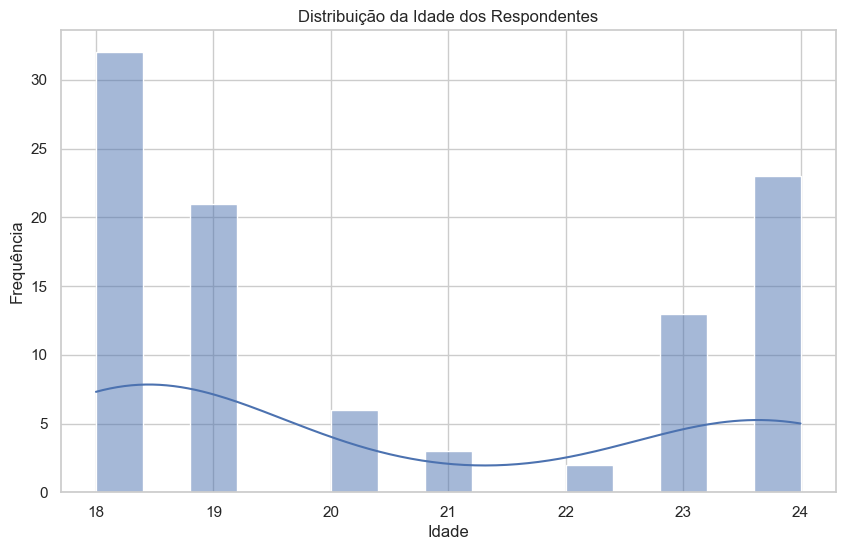

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True, bins=15)
plt.title('Distribuição da Idade dos Respondentes')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

Distribuição de Gênero

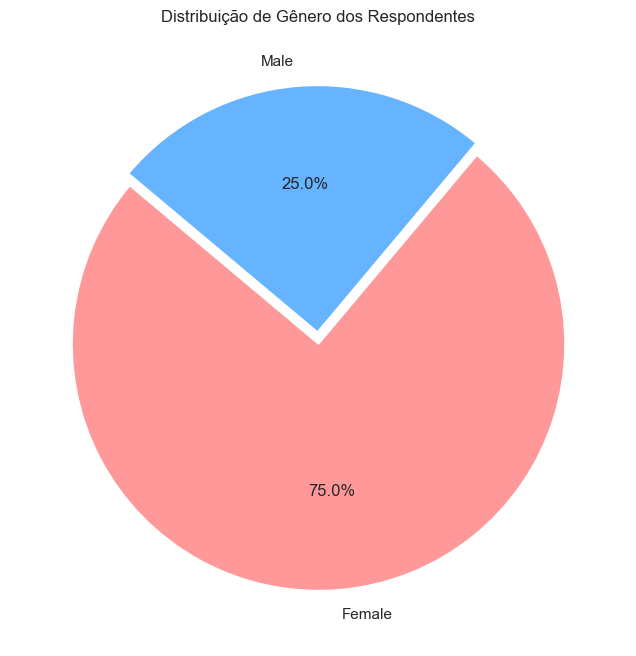

In [ ]:
plt.figure(figsize=(8, 8))
gender_counts = df['gender'].map({1: 'Female', 0: 'Male'}).value_counts()
plt.pie(
  gender_counts,
  labels=gender_counts.index,
  explode=(0.025, 0.025),
  colors=['#FF9999', '#66B3FF'],
  autopct='%1.1f%%',
  startangle=140
)
plt.title('Distribuição de Gênero dos Respondentes')
plt.show()

Distribuição por Ano de Estudo

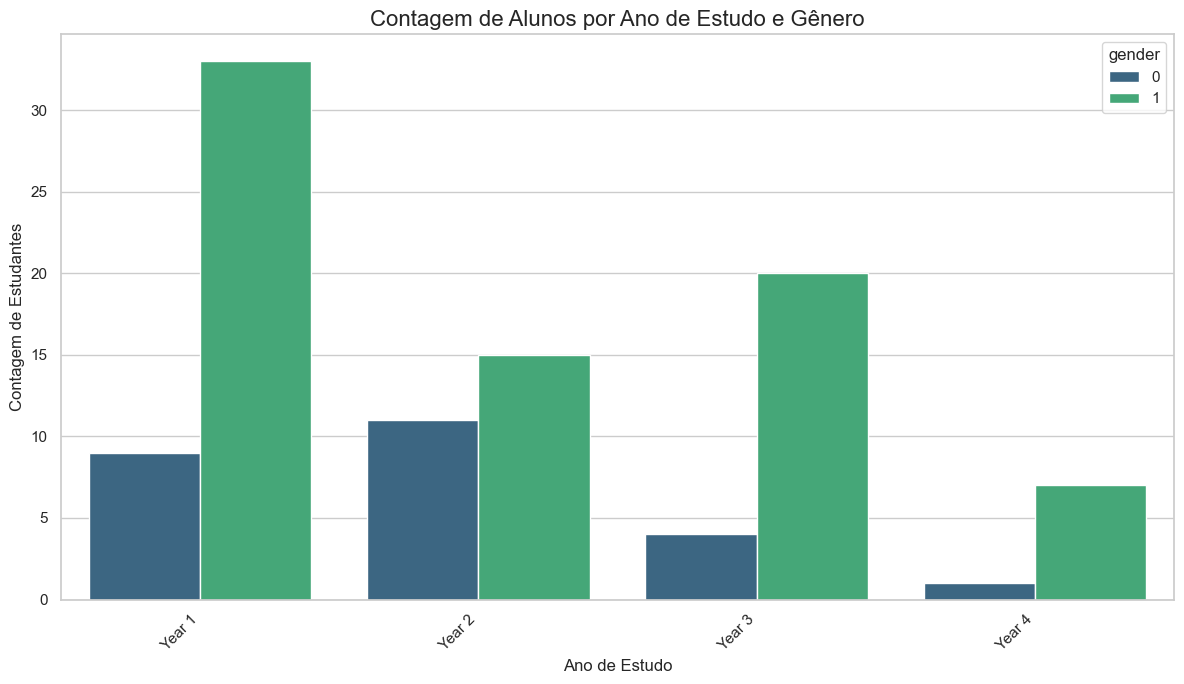

In [ ]:
plotar_countplot_hue(
    dataframe=df.sort_values('Your current year of Study'),
    x_col='Your current year of Study',
    hue_col='gender',
    title='Contagem de Alunos por Ano de Estudo e Gênero',
    xlabel='Ano de Estudo'
)

#### 5.2 Análise de Prevalência e Comorbidade

Relação entre Ansiedade e Depressão

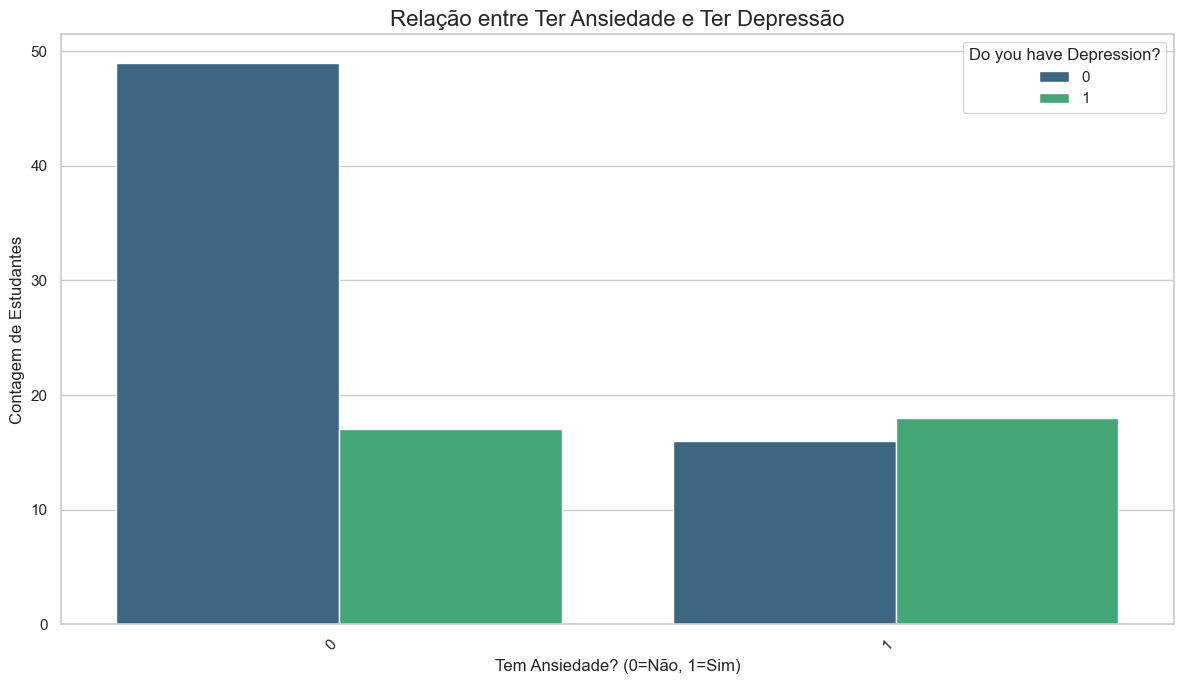

In [ ]:
plotar_countplot_hue(
    dataframe=df,
    x_col='Do you have Anxiety?',
    hue_col='Do you have Depression?',
    title='Relação entre Ter Ansiedade e Ter Depressão',
    xlabel='Tem Ansiedade? (0=Não, 1=Sim)'
)

Prevalência de Depressão por Gênero 

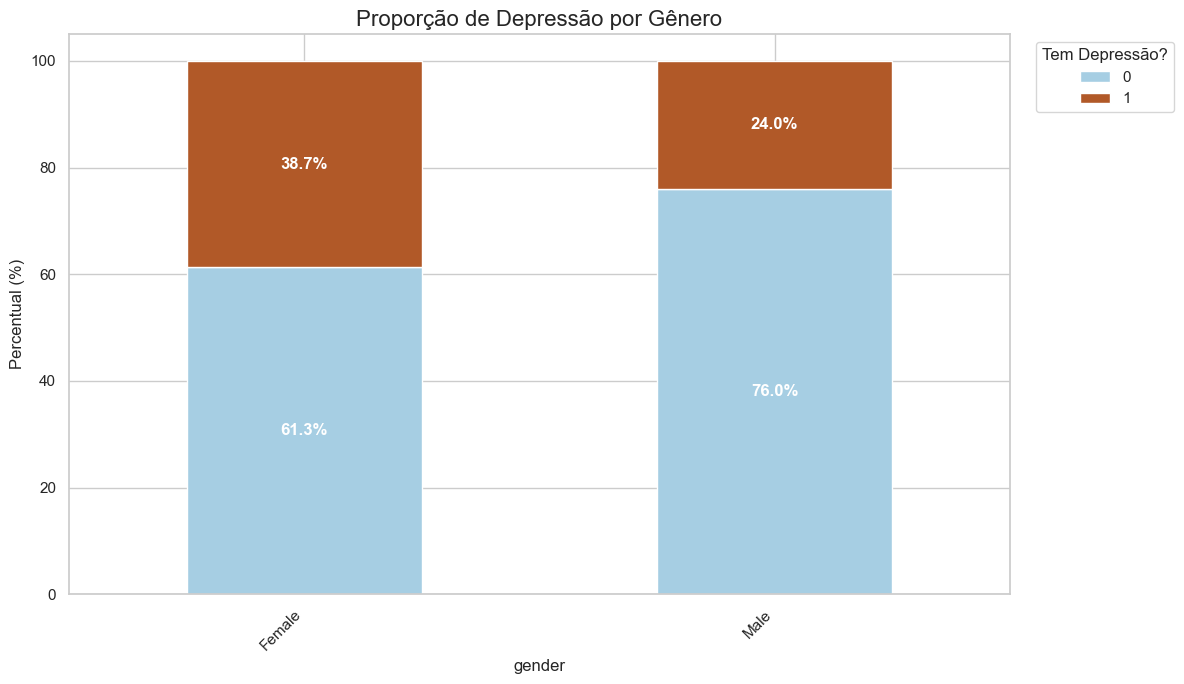

In [ ]:
df_plot = df.copy()
df_plot['gender'] = df_plot['gender'].map({1: 'Female', 0: 'Male'})
plotar_proporcao_empilhada(
    dataframe=df_plot,
    index_col='gender',
    columns_col='Do you have Depression?',
    title='Proporção de Depressão por Gênero',
    legend_title='Tem Depressão?'
)

Prevalência de Ansiedade por Gênero

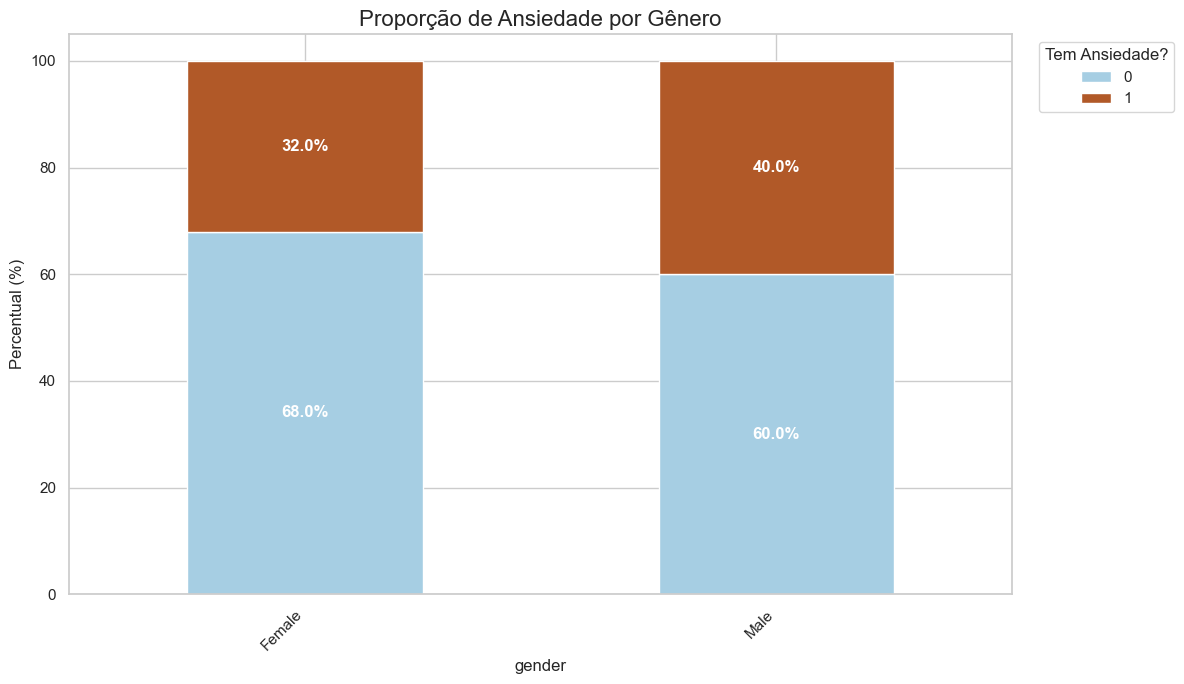

In [ ]:
plotar_proporcao_empilhada(
    dataframe=df_plot,
    index_col='gender',
    columns_col='Do you have Anxiety?',
    title='Proporção de Ansiedade por Gênero',
    legend_title='Tem Ansiedade?'
)

Prevalência de Depressão por Ano de Estudo (Gráfico de Proporção)

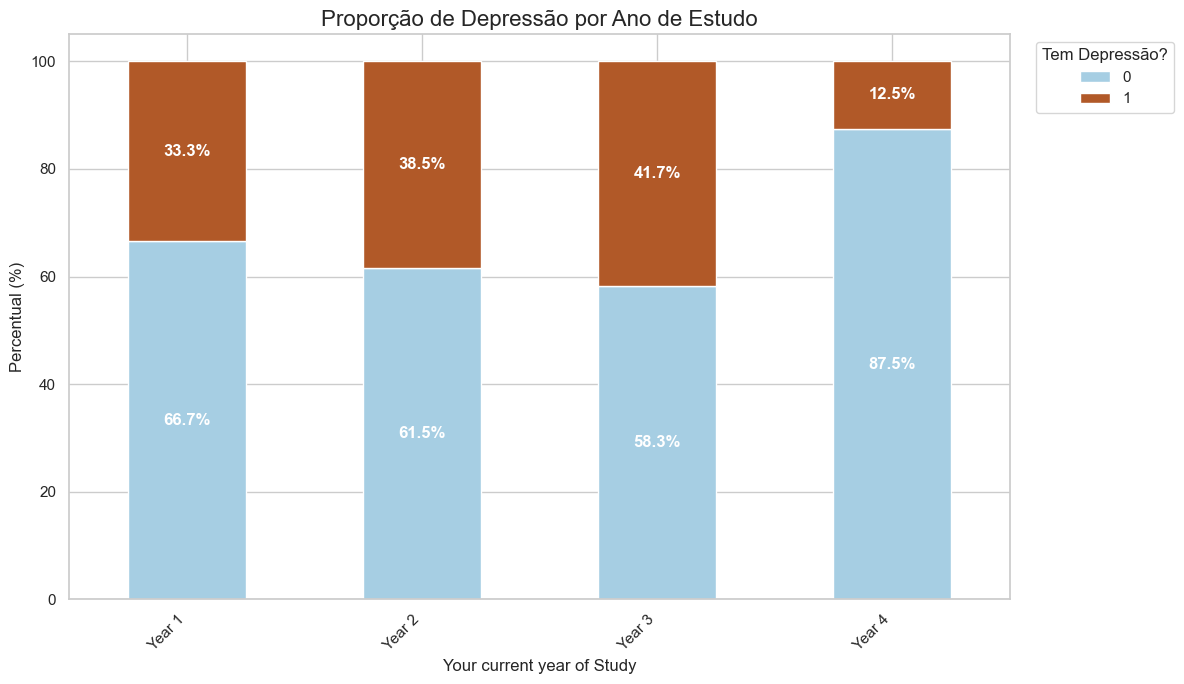

In [ ]:

plotar_proporcao_empilhada(
    dataframe=df.sort_values('Your current year of Study'),
    index_col='Your current year of Study',
    columns_col='Do you have Depression?',
    title='Proporção de Depressão por Ano de Estudo',
    legend_title='Tem Depressão?'
)

#### 5.3 Análise do Desempenho

Prevalência de Ansiedade e Depressão por Faixa de CGPA

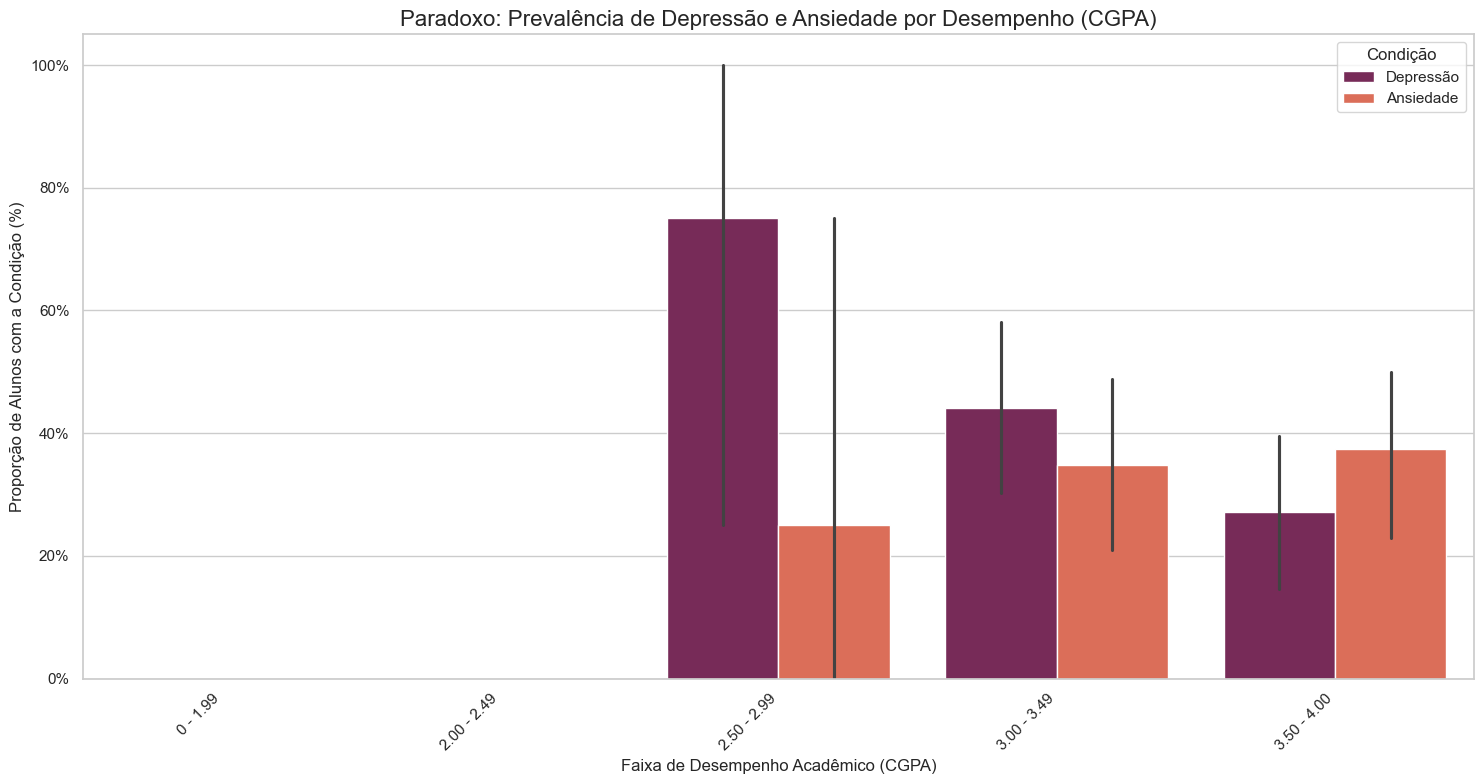

In [ ]:
df_paradoxo = df.melt(
    id_vars=['What is your CGPA?'],
    value_vars=['Do you have Depression?', 'Do you have Anxiety?'],
    var_name='Condição',
    value_name='Prevalência'
)

df_paradoxo['Condição'] = df_paradoxo['Condição'].map({
    'Do you have Depression?': 'Depressão',
    'Do you have Anxiety?': 'Ansiedade'
})

ordem_cgpa = sorted(df['What is your CGPA?'].unique())

plt.figure(figsize=(15, 8))
ax = sns.barplot(
    data=df_paradoxo,
    x='What is your CGPA?',
    y='Prevalência',
    hue='Condição',
    order=ordem_cgpa,
    palette='rocket'
)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.title('Paradoxo: Prevalência de Depressão e Ansiedade por Desempenho (CGPA)', fontsize=16)
plt.xlabel('Faixa de Desempenho Acadêmico (CGPA)', fontsize=12)
plt.ylabel('Proporção de Alunos com a Condição (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 5.4 Análise por Área de Estudo Agrupada

Prevalência das 3 Condições por Área de Estudo Agrupada

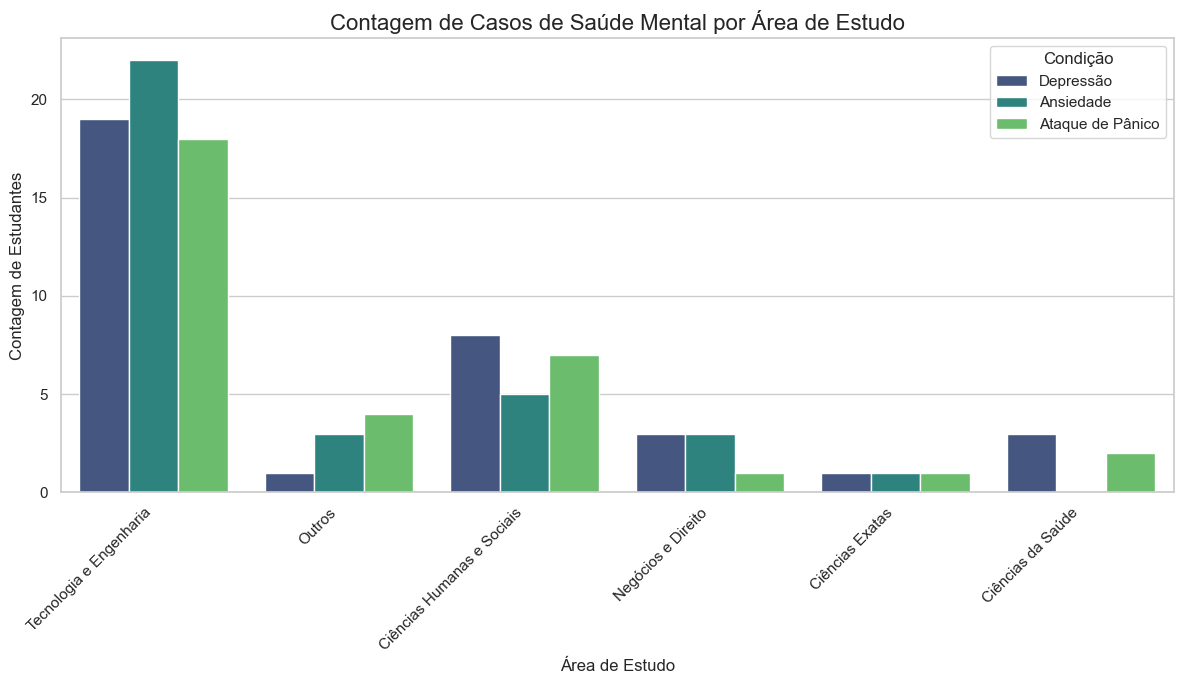

In [ ]:
df_melted_area = df.melt(
    id_vars=['Area_de_Estudo'],
    value_vars=['Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?'],
    var_name='Condição',
    value_name='Prevalência'
)

df_melted_area['Condição'] = df_melted_area['Condição'].map({
    'Do you have Depression?': 'Depressão',
    'Do you have Anxiety?': 'Ansiedade',
    'Do you have Panic attack?': 'Ataque de Pânico'
})

plotar_countplot_hue(
    dataframe=df_melted_area[df_melted_area['Prevalência']==1],
    x_col='Area_de_Estudo',
    hue_col='Condição',
    title='Contagem de Casos de Saúde Mental por Área de Estudo',
    xlabel='Área de Estudo'
)

### 6. Análise de Correlação

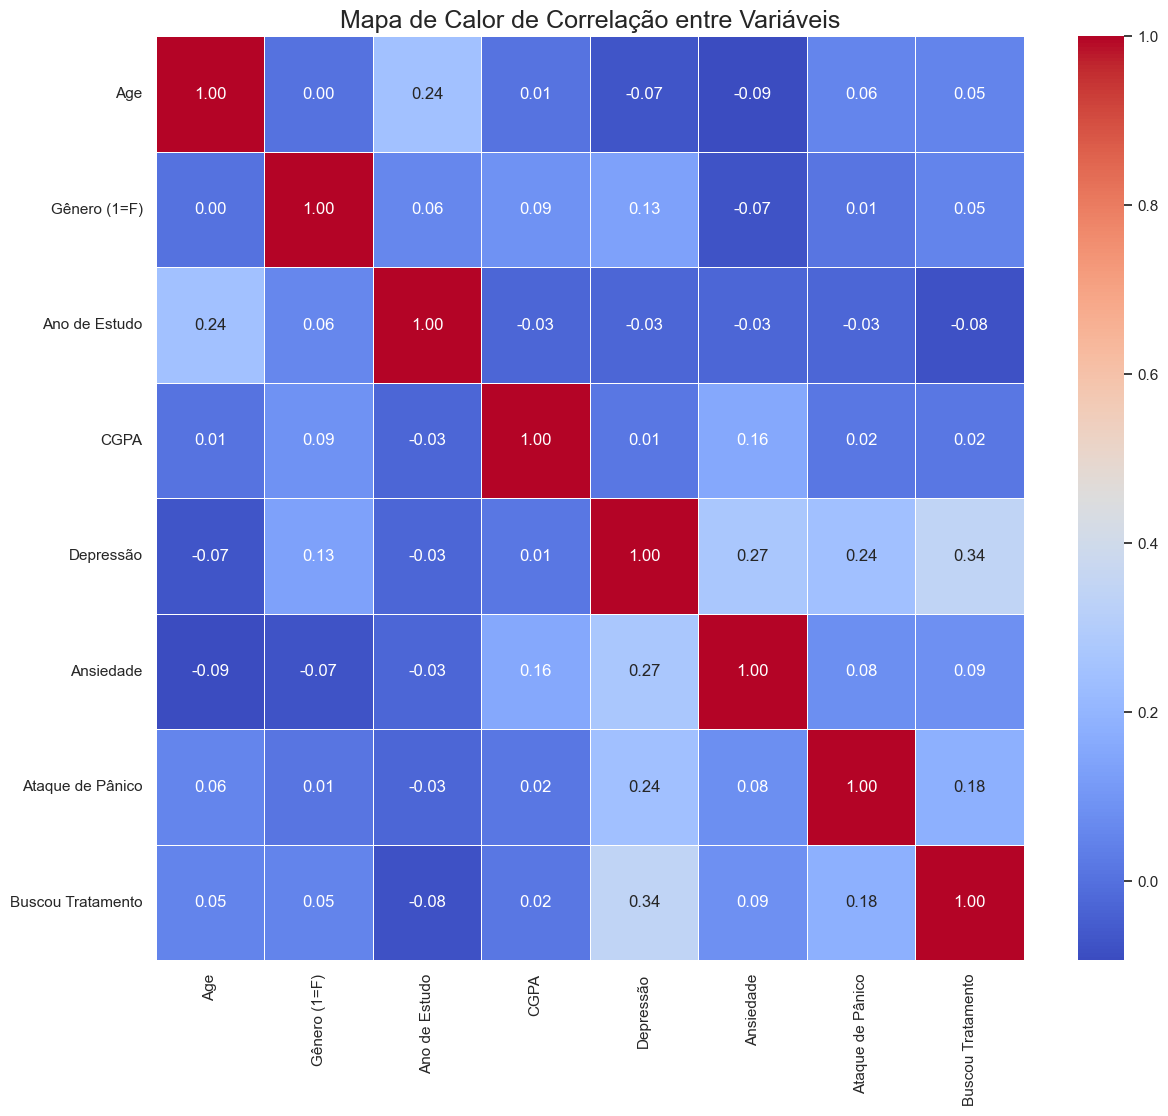

In [26]:
df_for_heatmap = df[[
    'Age', 'gender', 'Year_of_Study_num', 'CGPA_numeric', 
    'Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?', 
    'Did you seek any specialist for a treatment?'
]].rename(columns={
    'gender': 'Gênero (1=F)', 'Year_of_Study_num': 'Ano de Estudo', 'CGPA_numeric': 'CGPA',
    'Do you have Depression?': 'Depressão', 'Do you have Anxiety?': 'Ansiedade',
    'Do you have Panic attack?': 'Ataque de Pânico', 'Did you seek any specialist for a treatment?': 'Buscou Tratamento'
})

corr_matrix = df_for_heatmap.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor de Correlação entre Variáveis', fontsize=18)
plt.show()

## Machine Learning
- Objetivo: Construir um modelo de classificação.
- Pergunta: Com base na idade, gênero, ano de estudo, notas (CGPA) e área de estudo de um aluno, podemos prever se ele tem depressão?

##### Preparação Final dos Dados para o Modelo

In [30]:
features = [
    'Age',
    'gender',
    'Year_of_Study_num',
    'CGPA_numeric',
    'Area_de_Estudo'
]
target = 'Do you have Depression?'

X = df[features]
y = df[target]

X = pd.get_dummies(X, columns=['Area_de_Estudo'], drop_first=True)

print("Formato das nossas features (X) após One-Hot Encoding:", X.shape)
print("Prévia das features:")
X.head()

Formato das nossas features (X) após One-Hot Encoding: (100, 9)
Prévia das features:


,Age,gender,Year_of_Study_num,CGPA_numeric,Area_de_Estudo_Ciências Humanas e Sociais,Area_de_Estudo_Ciências da Saúde,Area_de_Estudo_Negócios e Direito,Area_de_Estudo_Outros,Area_de_Estudo_Tecnologia e Engenharia
0,18.0,1,1,3.245,False,False,False,False,True
1,21.0,0,2,3.245,False,False,False,True,False
2,19.0,0,1,3.245,False,False,False,False,True
3,22.0,1,3,3.245,False,False,False,True,False
4,23.0,0,4,3.245,False,False,False,True,False


##### Divisão dos Dados em Treino e Teste

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")

Tamanho do conjunto de treino: 70 amostras
Tamanho do conjunto de teste: 30 amostras


CÁLCULO DO PESO PARA DADOS DESBALANCEADOS

In [82]:
counter = Counter(y_train)
scale_pos_weight_value = counter[0] / counter[1]

##### Escolha e Treinamento do Modelo

In [60]:
modelo = LogisticRegression(random_state=42, class_weight='balanced')
modelo.fit(X_train_scaled, y_train)
print("Modelo treinado com sucesso!")

Modelo treinado com sucesso!


##### Avaliação do Desempenho do Modelo

Acurácia do modelo: 50.00%

Relatório de Classificação:
                   precision    recall  f1-score   support

Sem Depressão (0)       0.73      0.40      0.52        20
Com Depressão (1)       0.37      0.70      0.48        10

         accuracy                           0.50        30
        macro avg       0.55      0.55      0.50        30
     weighted avg       0.61      0.50      0.51        30



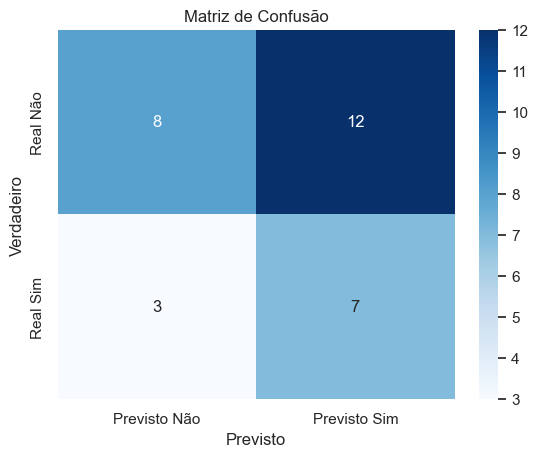

In [61]:
y_pred = modelo.predict(X_test_scaled)

acuracia = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {acuracia:.2%}\n")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Sem Depressão (0)', 'Com Depressão (1)']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Previsto Não', 'Previsto Sim'], 
            yticklabels=['Real Não', 'Real Sim'])
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

In [62]:
coeficientes = pd.DataFrame(
    data=modelo.coef_[0],
    index=X.columns,
    columns=['Coeficiente']
).sort_values('Coeficiente', ascending=False)

print("Importância de cada fator para o modelo:")
print(coeficientes)

Importância de cada fator para o modelo:
                                           Coeficiente
Area_de_Estudo_Tecnologia e Engenharia        0.298749
gender                                        0.289613
Area_de_Estudo_Ciências Humanas e Sociais     0.193207
Area_de_Estudo_Negócios e Direito             0.180800
Year_of_Study_num                             0.039156
Area_de_Estudo_Ciências da Saúde             -0.022785
CGPA_numeric                                 -0.031390
Age                                          -0.200927
Area_de_Estudo_Outros                        -0.636899


#### Treinamento com o Random Forest

In [63]:
modelo_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
modelo_rf.fit(X_train_scaled, y_train)
print("Modelo Random Forest treinado com sucesso!\n")

Modelo Random Forest treinado com sucesso!



Acurácia do Modelo Random Forest: 46.67%

Relatório de Classificação (Random Forest):
                   precision    recall  f1-score   support

Sem Depressão (0)       0.59      0.65      0.62        20
Com Depressão (1)       0.12      0.10      0.11        10

         accuracy                           0.47        30
        macro avg       0.36      0.38      0.37        30
     weighted avg       0.44      0.47      0.45        30



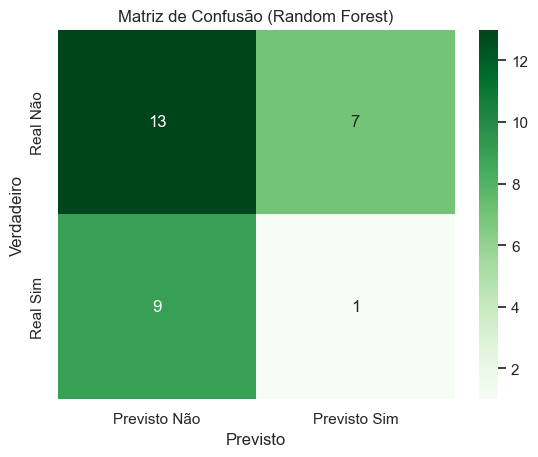

In [64]:
y_pred_rf = modelo_rf.predict(X_test_scaled)

acuracia_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia do Modelo Random Forest: {acuracia_rf:.2%}\n")

print("Relatório de Classificação (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Sem Depressão (0)', 'Com Depressão (1)']))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Greens',
            xticklabels=['Previsto Não', 'Previsto Sim'],
            yticklabels=['Real Não', 'Real Sim'])
plt.title('Matriz de Confusão (Random Forest)')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

In [83]:
modelos = {
    "Regressão Logística": LogisticRegression(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "SVM (Linear)": SVC(random_state=42, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_value, verbosity=0),
    "CatBoost": cat.CatBoostClassifier(random_state=42, scale_pos_weight=scale_pos_weight_value, verbose=0)
}

resultados = {}

In [84]:
for nome, modelo in modelos.items():

    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)

    f1 = f1_score(y_test, y_pred, pos_label=1)

    resultados[nome] = f1

    print(f"--- Resultados para: {nome} ---")
    print(f"F1-Score (Com Depressão): {f1:.2%}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("="*40 + "\n")

--- Resultados para: Regressão Logística ---
F1-Score (Com Depressão): 48.28%
              precision    recall  f1-score   support

           0       0.73      0.40      0.52        20
           1       0.37      0.70      0.48        10

    accuracy                           0.50        30
   macro avg       0.55      0.55      0.50        30
weighted avg       0.61      0.50      0.51        30


--- Resultados para: Random Forest ---
F1-Score (Com Depressão): 11.11%
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        20
           1       0.12      0.10      0.11        10

    accuracy                           0.47        30
   macro avg       0.36      0.38      0.37        30
weighted avg       0.44      0.47      0.45        30


--- Resultados para: Gradient Boosting ---
F1-Score (Com Depressão): 12.50%
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        20
         

--- Ranking Final dos Modelos ---
                           F1-Score (Com Depressão)
Gaussian Naive Bayes                       0.533333
Regressão Logística                        0.482759
SVM (Linear)                               0.437500
K-Nearest Neighbors (KNN)                  0.235294
Gradient Boosting                          0.125000
Random Forest                              0.111111
XGBoost                                    0.105263
CatBoost                                   0.100000


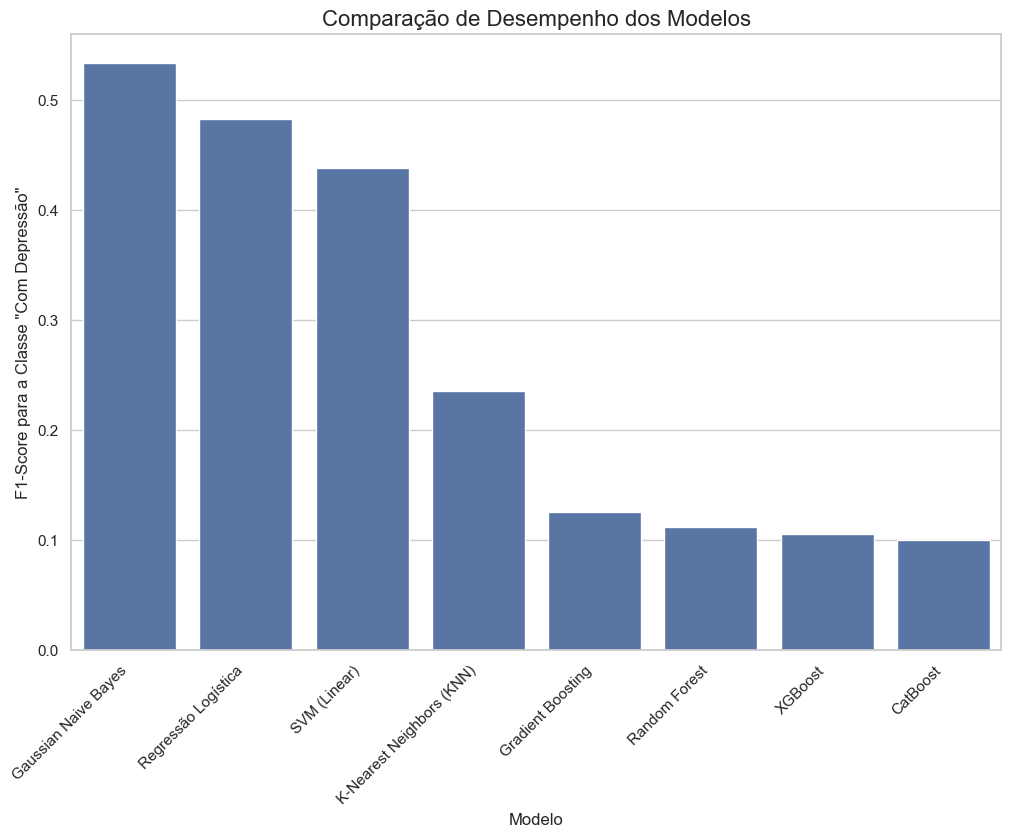

In [85]:
df_resultados = pd.DataFrame.from_dict(resultados, orient='index', columns=['F1-Score (Com Depressão)'])
df_resultados = df_resultados.sort_values(by='F1-Score (Com Depressão)', ascending=False)

print("--- Ranking Final dos Modelos ---")
print(df_resultados)

plt.figure(figsize=(12, 8))
sns.barplot(x=df_resultados.index, y=df_resultados['F1-Score (Com Depressão)'])
plt.title('Comparação de Desempenho dos Modelos', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('F1-Score para a Classe "Com Depressão"', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


In [86]:
features = ['Age', 'gender', 'Year_of_Study_num', 'CGPA_numeric', 'Area_de_Estudo']
target = 'Do you have Depression?'

X = df[features]
y = df[target]
X = pd.get_dummies(X, columns=['Area_de_Estudo'], drop_first=True)

colunas_modelo = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

modelo_final_nb = GaussianNB()
modelo_final_nb.fit(X_train_scaled, y_train)

print("Modelo Gaussian Naive Bayes final treinado com sucesso.")

nome_arquivo_modelo = 'modelo_naive_bayes.pkl'
nome_arquivo_scaler = 'scaler.pkl'
nome_arquivo_colunas = 'colunas_modelo.pkl'

joblib.dump(modelo_final_nb, nome_arquivo_modelo)
joblib.dump(scaler, nome_arquivo_scaler)
joblib.dump(colunas_modelo, nome_arquivo_colunas)

print(f"\nModelo salvo com sucesso no arquivo: '{nome_arquivo_modelo}'")
print(f"Scaler salvo com sucesso no arquivo: '{nome_arquivo_scaler}'")
print(f"Lista de colunas salva com sucesso no arquivo: '{nome_arquivo_colunas}'")

Modelo Gaussian Naive Bayes final treinado com sucesso.

Modelo salvo com sucesso no arquivo: 'modelo_naive_bayes.pkl'
Scaler salvo com sucesso no arquivo: 'scaler.pkl'
Lista de colunas salva com sucesso no arquivo: 'colunas_modelo.pkl'
